# Spatial autocorrelation 
* Guides with codes on https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html
* Here we use data aggregated by CDUID
    * /dataset/canada-census-division/CD-download-data.shp
* Boundary data obtained from https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2016-eng.cfm



In [ ]:
# To do:
# Test this with no external boundary data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install geopandas &> /dev/null
import os
import pandas as pd
import pickle
import geopandas as gpd
import numpy as np

# Autocorrelation and plotting modules
!pip install pysal contextily &> /dev/null
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran

import contextily
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/dataset/')
print(os.getcwd())

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


/content/drive/MyDrive/shared/dataset


Here we perform spatial autocorrelation using the aggregated data.

In [15]:
# Load CD downlaod data
# dat_path = './canada-census-division/CD-download-data.shp'
dat_path = './canada-da-boundaries/DA-download-data.shp'

dat = gpd.read_file(dat_path)
print(dat.shape)
print(dat.columns)
dat.head(5)

(56589, 37)
Index(['DAUID', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME', 'CDTYPE', 'CCSUID',
       'CCSNAME', 'CSDUID', 'CSDNAME', 'CSDTYPE', 'ERUID', 'ERNAME', 'SACCODE',
       'SACTYPE', 'CMAUID', 'CMAPUID', 'CMANAME', 'CMATYPE', 'CTUID', 'CTNAME',
       'ADAUID', '2019-Q1', '2019-Q2', '2019-Q3', '2019-Q4', '2020-Q1',
       '2020-Q2', '2020-Q3', '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3',
       '2021-Q4', 'tests', 'DA_POP', 'geometry'],
      dtype='object')


,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,...,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
0,10010244,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8976851.149 2149576.543, 8976818.149..."
1,10010245,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977202.180 2150836.794, 8977136.277..."
2,10010246,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977549.383 2150892.566, 8977492.269..."
3,10010247,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977682.314 2151083.183, 8977689.440..."
4,10010248,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8978152.474 2151142.586, 8978040.654..."


In [16]:
dat.info() ## it looks like there are still null values.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56589 entries, 0 to 56588
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DAUID     56589 non-null  object  
 1   PRUID     56589 non-null  object  
 2   PRNAME    56589 non-null  object  
 3   CDUID     56589 non-null  object  
 4   CDNAME    56589 non-null  object  
 5   CDTYPE    56589 non-null  object  
 6   CCSUID    56589 non-null  object  
 7   CCSNAME   56589 non-null  object  
 8   CSDUID    56589 non-null  object  
 9   CSDNAME   56589 non-null  object  
 10  CSDTYPE   56589 non-null  object  
 11  ERUID     56589 non-null  object  
 12  ERNAME    56589 non-null  object  
 13  SACCODE   56589 non-null  object  
 14  SACTYPE   56589 non-null  object  
 15  CMAUID    43746 non-null  object  
 16  CMAPUID   43746 non-null  object  
 17  CMANAME   43746 non-null  object  
 18  CMATYPE   43746 non-null  object  
 19  CTUID     38289 non-null  object  
 20

In [17]:
inds = np.unique(np.where(pd.isnull(dat['2021-Q4']))[0])
dat.loc[inds]

,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,...,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
0,10010244,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8976851.149 2149576.543, 8976818.149..."
1,10010245,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977202.180 2150836.794, 8977136.277..."
2,10010246,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977549.383 2150892.566, 8977492.269..."
3,10010247,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8977682.314 2151083.183, 8977689.440..."
4,10010248,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,1001519,St. John's,1001519,St. John's,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((8978152.474 2151142.586, 8978040.654..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56581,59390189,59,British Columbia / Colombie-Britannique,5939,Columbia-Shuswap,RD,5939039,Columbia-Shuswap D,5939032,Salmon Arm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4336932.623 2025546.631, 4337151.209..."
56582,59530199,59,British Columbia / Colombie-Britannique,5953,Fraser-Fort George,RD,5953048,Fraser-Fort George F,5953033,Mackenzie,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1040.0,"POLYGON ((4339069.071 2595378.469, 4337222.406..."
56586,59530208,59,British Columbia / Colombie-Britannique,5953,Fraser-Fort George,RD,5953042,Fraser-Fort George C,5953023,Prince George,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4283348.986 2454686.740, 4283327.897..."
56587,59530209,59,British Columbia / Colombie-Britannique,5953,Fraser-Fort George,RD,5953042,Fraser-Fort George C,5953023,Prince George,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4282932.354 2455406.546, 4283303.163..."


In [5]:
cond = dat['PRNAME']=='Nunavut'
dat[cond]

,CDUID,CDNAME,CDTYPE,PRUID,PRNAME,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
290,6204,Baffin,REG,62,Nunavut,NaN,NaN,NaN,53.06,32.034,NaN,NaN,NaN,15.615333,8.527091,7.61125,14.778941,102,85875.0,"MULTIPOLYGON (((7020343.300 3239921.443, 70203..."
291,6205,Keewatin,REG,62,Nunavut,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,3535.0,"MULTIPOLYGON (((6193825.809 3390255.469, 61943..."
292,6208,Kitikmeot,REG,62,Nunavut,NaN,NaN,NaN,NaN,NaN,3.92,NaN,17.948,NaN,NaN,NaN,NaN,2,0.0,"MULTIPOLYGON (((6105932.626 3935743.411, 61062..."


In [18]:
# with open('./python_canada-speed-data.p', 'rb') as file:
#   canada = pickle.load(file)

In [19]:
dat2 = dat.drop(inds)

In [20]:
dat2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14541 entries, 5 to 56585
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DAUID     14541 non-null  object  
 1   PRUID     14541 non-null  object  
 2   PRNAME    14541 non-null  object  
 3   CDUID     14541 non-null  object  
 4   CDNAME    14541 non-null  object  
 5   CDTYPE    14541 non-null  object  
 6   CCSUID    14541 non-null  object  
 7   CCSNAME   14541 non-null  object  
 8   CSDUID    14541 non-null  object  
 9   CSDNAME   14541 non-null  object  
 10  CSDTYPE   14541 non-null  object  
 11  ERUID     14541 non-null  object  
 12  ERNAME    14541 non-null  object  
 13  SACCODE   14541 non-null  object  
 14  SACTYPE   14541 non-null  object  
 15  CMAUID    5639 non-null   object  
 16  CMAPUID   5639 non-null   object  
 17  CMANAME   5639 non-null   object  
 18  CMATYPE   5639 non-null   object  
 19  CTUID     3811 non-null   object  
 20

In [24]:
# cols = np.append(np.array(dat2.columns[range(5,17)]), dat2.columns[19])
cols = ['DAUID', '2019-Q1', '2019-Q2','2019-Q3', '2019-Q4','2020-Q1',	'2020-Q2',	'2020-Q3',	'2020-Q4',	'2021-Q1',	'2021-Q2',	'2021-Q3',	'2021-Q4', 'tests','DA_POP', 'geometry']

In [26]:
sub_dat = dat2[cols]
# sub_dat = dat2[cols]
sub_dat.head()

,DAUID,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,tests,DA_POP,geometry
5,10010249,NaN,NaN,NaN,NaN,NaN,6.721000,1.639000,NaN,NaN,52.068000,39.515000,154.563000,70.0,6110.0,"POLYGON ((8977690.386 2151443.737, 8977686.806..."
49,10010191,97.366333,117.839300,142.273923,216.091000,157.276556,117.459250,90.400814,168.794455,142.713238,234.337602,129.232029,135.353682,820.0,48575.0,"POLYGON ((8981987.986 2153965.966, 8981992.077..."
98,10010486,58.868750,79.212000,46.574429,103.873200,155.954000,57.149000,285.421000,167.028786,158.998556,112.139167,209.289731,133.595400,216.0,37950.0,"POLYGON ((8981595.731 2155809.606, 8981603.223..."
107,10010496,96.455000,1.825191,16.800500,72.112500,81.069000,20.306933,28.656455,49.555909,48.839915,83.304636,56.000000,1.299000,201.0,11060.0,"POLYGON ((8935642.709 2196311.271, 8935686.551..."
108,10010497,118.833000,33.624000,194.869612,77.605857,160.630833,175.920000,265.376333,128.304200,73.366615,93.629333,76.171300,238.869429,148.0,22080.0,"MULTIPOLYGON (((8928320.397 2199041.249, 89283..."


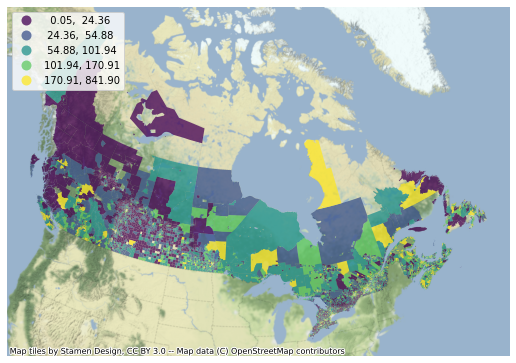

In [27]:
f, ax = plt.subplots(1, figsize=(9,9))
sub_dat.plot(column = '2021-Q4',
             cmap='viridis',
             scheme='quantiles',
             k=5,
             edgecolor='white',
             linewidth=0,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             ax=ax)

contextily.add_basemap(ax, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

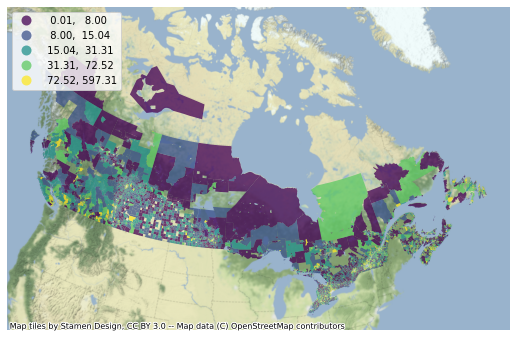

In [28]:
f, ax = plt.subplots(1, figsize=(9,9))
sub_dat.plot(column = '2019-Q1',
             cmap='viridis',
             scheme='quantiles',
             k=5,
             edgecolor='white',
             linewidth=0,
             alpha=0.75,
             legend=True,
             legend_kwds={'loc':2},
             ax=ax)

contextily.add_basemap(ax, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

## Apply smoothing by global autocorrelation using Spatial lag
* Spatial lag provides 'weighted average' of neighbouring tiles


In [ ]:
# Global autocorrelation

# Smooths out the borders by the k nearest neighbours

w = weights.KNN.from_dataframe(sub_dat, k=20) # larger the k, smoother the boundaries

w.transform = 'R' # row-standardization

sub_dat['2021-Q4_lag'] = weights.spatial_lag.lag_spatial(w, sub_dat['2021-Q4'])


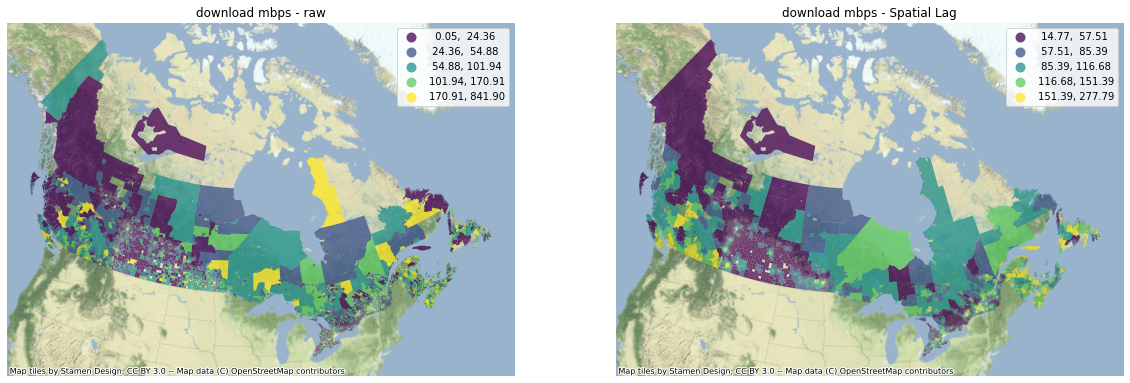

In [36]:
## Plot 
f, axs = plt.subplots(1, 2, figsize=(20,20))
ax1, ax2 = axs

sub_dat.plot(column='2021-Q4', cmap='viridis', scheme='quantiles',
        k=5, 
        edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1,
        figsize=(20,20))
ax1.set_axis_off()
ax1.set_title("download mbps - raw")
contextily.add_basemap(ax1, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )

sub_dat.plot(column='2021-Q4_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2,
        figsize=(20,20))
ax2.set_axis_off()
ax2.set_title("download mbps - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )

plt.show()

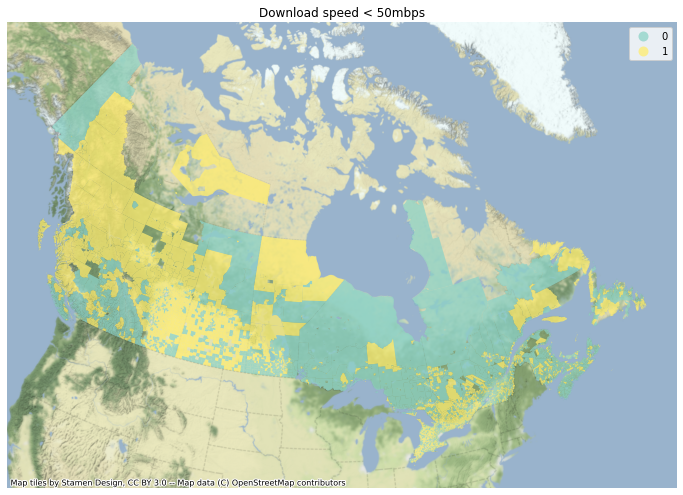

In [39]:
# binary case: classify mbps < 50

sub_dat['slow'] = (sub_dat['2021-Q4'] < 50).astype(int)
# sub_dat[['2021-Q4', 'slow']].tail()

f, ax = plt.subplots(1, figsize=(12, 12))
sub_dat.plot(ax=ax, column='slow', categorical=True, legend=True, 
        edgecolor='0.5', linewidth=0., alpha=0.75, 
        cmap='Set3' 
        # cmap = 'viridis'
        );
ax.set_axis_off()
ax.set_title('Download speed < 50mbps')
contextily.add_basemap(ax, 
                       crs=sub_dat.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                      )
# plt.axis('equal')
plt.show()

It looks like it is more common to have internet speed $<$50 mbps in the western part of the country.